## Import packages

In [170]:
import pandas as pd
import numpy as np
from typing import Union
from IPython.display import display
import matplotlib as plt
from graphviz import Digraph

## Declare Classes 

In [345]:
class Node:
  """A single node in decision Tree is defined as tree whose each node is carachterized by a set of attributes : 
  - redirection->dict : it takes the coming condition and redirects it the corresponding child
  - entropy->float : the entropy of the node
  - parent->Node : points to the parent of the actual node, we need it when we calculate the information gain
  - children->List : it's the list of children to which node points"""
  def __init__(self, attribute=None, entropy=None, parent=None, target = None, X=None, y=None):
    self.attribute = attribute
    self.redirection = None
    self.entropy = entropy
    self.parent = parent
    self.target = target
    self.X = X
    self.y = y

  """Display the node's content.
  - datafram : bool : `True` if the user want to display them as DataFrame, else it will display them by printing them."""
  def show_node(self, dataframe=True):
    if not dataframe :
      print(f'{"Attribute":-<50}{self.attribute}')
      print(f'{"Entropy":-<50}{self.entropy}')
      print(f'{"Target":-<50}{self.target}')

      if self.redirection is not None :
        print(f'{"Conditions":-<50}{self.redirection.keys()}')
  
    else :
      columns = ["Attribute", "Entropy", "Target"]
      values = [self.attribute, self.entropy, self.target]
      if self.redirection is not None :
        columns.append("Conditions")
        values.append(self.redirection.keys())
      display(pd.DataFrame({"":values}, index=columns))
    
    display(self.X)
    display(self.y)
    

In [469]:
class DecisionTree:
  """We declared our decision tree as a structure as we used to do in C. It's caracterized by root."""
  def __init__(self):
    self.root = None

  """We declared entropy and information_gain methods in mathematical point of view"""
  def entropy(self, probs)->float:
    logs = np.log2(probs)

    return -np.matmul(probs, logs.T)

  def information_gain(self, parent_ent, children_ent, coefs)->float:
    return parent_ent-np.matmul(np.array(coefs), np.array(children_ent).T) 

  """Get the index of element having the maximal value, we need it to associate each training example to its class"""
  def argmax(self, probs):
      return probs.index[np.argmax(probs)][0]


  """This method calculates the information gain of each node, then it returns the attribute which has the higher information gain, it takes the following parameters :
  - parent_entropy : to calculate the information gain of each attribute, we should have the parent's entropy
  - X : dataset without target, we use it to calculate the entropy of each column. """
  def select_attribute(self, parent: Node) -> Node:
    X = parent.X
    y = parent.y

    ig = -np.Inf
    for col in X.columns :
      X_col = pd.DataFrame({col : X[col]})
      unique_values = np.unique(X_col)
      
      # Splits the dataset into small datasets in which each one contains just instances of single value of column `col`
      redirection = {}
      weights = []
      entropies = []

      for val in unique_values :

        mask = np.array(X_col == val)
        tmp = y[mask]
        
        # Compute the entropy of the node and its associated weight
        probs = pd.DataFrame(tmp).value_counts(normalize=True)
        ent = self.entropy(probs)
        weight = len(tmp)/len(X)

        # Create the node and set the target to the majority

        node = Node(parent=parent, entropy=ent, target=self.argmax(probs), X=X[mask], y=y[mask])
        
        # `and val:node` to redirection dictionnary
        redirection[val] = node

        # Add weight and ent to weights and entropies lists respectively
        weights.append(weight)
        entropies.append(ent)
      
      tmp_ig = self.information_gain(parent.entropy, entropies, weights)

      if tmp_ig > ig :
        ig = tmp_ig

        # Update the parent informations
        parent.redirection = redirection
        parent.attribute = col 

    return parent

  """It's much more simple to visit the nodes of the tree with recursive manner than iterative one.
  - `iter->int` : number of iteration the decision tree will make before it classifies the new"""
  def recursive_visit(self, root, iter):
    if iter != 0 and root.redirection is not None and root.entropy !=0 :
        for n in root.redirection.values():
          self.select_attribute(n)
          self.recursive_visit(n, iter-1)
          
        

  """Train the model.
  - X, y->pd.DataFrame : Dataset"""
  def fit(self, X, y, iter=10):
    # Create root node with which we begin 
    probs_y = pd.DataFrame(y).value_counts(normalize=True)

    self.root = Node(entropy=self.entropy(probs_y), target=self.argmax(probs_y), X=X, y=y)
    self.root = self.select_attribute(self.root)

    # Create the different levels recursively. By default, we set the length of the tree to number of attributes of X
    self.recursive_visit(self.root, iter=iter)
  
  """Make predictions.
  - X->Union[np.ndarray, list, pd.DataFrame] : Inputs"""
  def predict(self, X: pd.DataFrame) -> np.ndarray:

    # Convert a standard list in python to numpy array
    if isinstance(X, list):
      X = np.array(X)

    # Store predictions in a list
    predictions = []

    # Iterate over the tree until the node's attribute is None or the entropy is 0 (pure node) and then we get its correponding class
    for i in range(len(X)):
      node = self.root
      while node.attribute is not None and node.entropy != 0 :
        if node.redirection is not None :
          for key, value in node.redirection.items() :
            if X.loc[i, node.attribute] == key:
              node = value
              break
      predictions.append(node.target)
    
    return np.array(predictions)
      
    

  """Show the resulted tree"""
  def show_tree(self):
    def create_graph(root, graph):
      if root is None :
        return
          
      graph.node(str(root), f"Attribute : {root.attribute}\nEntropy : {root.entropy:.6f}\nTarget : {root.target}")
      if root.redirection is not None :
        for key, n in root.redirection.items():
          if n is not None:
            graph.edge(str(root), str(n), f"{key}")
            create_graph(n, graph)

    graph = Digraph()
    create_graph(self.root, graph)
    display(graph)


## Train the model 

In [477]:
# Create a small dataset for training
x1 = np.array(["homme", "homme", "homme", "homme", "homme", "femme", "femme", "femme", "femme", "femme", "homme", "femme"])
x2 = np.array(["oui", "oui", "oui", "non", "oui", "oui", "non", "non", "oui", "non", "oui", "non"])
x3 = np.array(["adulte", "adolescent", "adulte", "adolescent", "adulte", "adulte", "adolescent", "adulte", "adulte", "adolescent", "adulte", "adolescent"])
y = np.array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0])
y = pd.DataFrame({"y" : y})
X = pd.DataFrame({"x1" : x1, "x2" : x2, "x3" : x3})
display(X.head())
display(y.head())

,x1,x2,x3
0,homme,oui,adulte
1,homme,oui,adolescent
2,homme,oui,adulte
3,homme,non,adolescent
4,homme,oui,adulte


,y
0,0
1,0
2,0
3,1
4,1


In [478]:
# Train the model
clf = DecisionTree()
clf.fit(X, y, iter=X.shape[1])

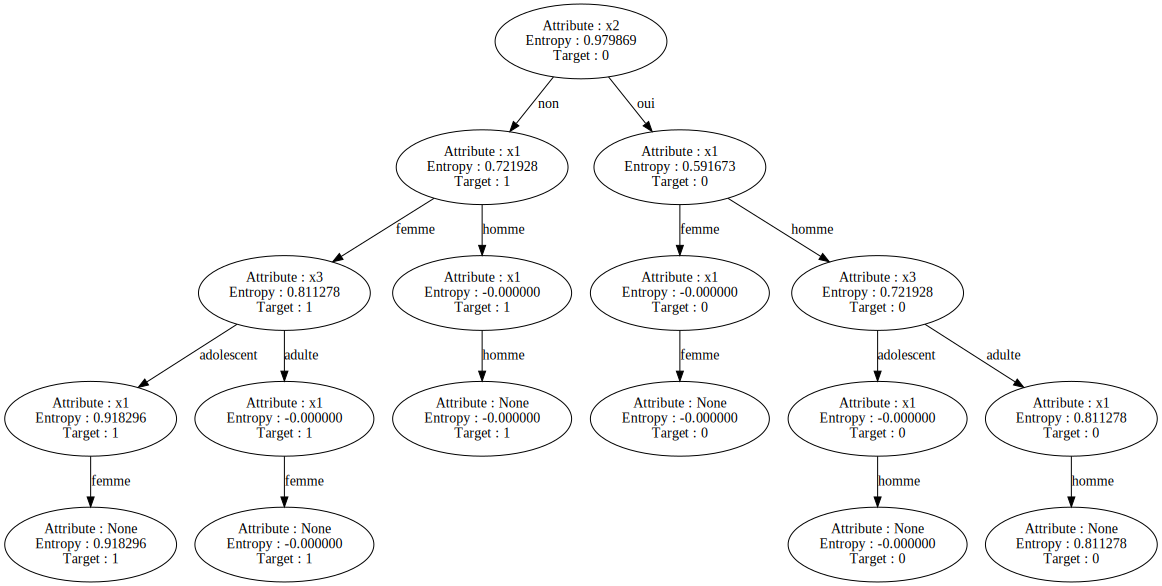

In [479]:
# We show the decision tree
clf.show_tree()

## Test the model

In [447]:
# Create small dataset for testing
x1_test = np.array(["femme", "homme", "homme", "femme"])
x2_test = np.array(["oui", "non", "oui", "non"])
x3_test = np.array(["adolescent", "adulte", "adulte", "adolescent"])
X_test = pd.DataFrame({"x1" : x1_test, "x2" : x2_test, "x3" : x3_test})

In [448]:
# Make predictions
clf.predict(X_test)

array([0, 1, 0, 1])